In [25]:
import pandas as pd
from tqdm import tqdm
import time
from multiprocessing import Pool, cpu_count
import numpy as np
import math
import hashlib
import itertools
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from scipy.stats import norm

# ==============================================================
# Utility functions: encoding, decoding, hashing
# ==============================================================

def encode_f(v, q, t):
    """
    f : Z_t^l -> Z_q^l
    Multiply by q/t and round (as in lecture notes)
    """
    scale = q / t
    return np.round(v * scale).astype(int) % q


def decode_f_inv(x, q, t):
    """
    f^{-1} : Z_q^l -> Z_t^l
    Divide by q/t and round, after centering
    """
    scale = q / t
    # center modulo q
    x_centered = np.where(x > q//2, x - q, x)
    return np.round(x_centered / scale).astype(int) % t


def derive_session_key(v, hash_fn="sha256"):
    """
    Derive session key by hashing message vector v
    (KEM-style key derivation)
    """
    v_bytes = v.astype(np.int16).tobytes()
    if hash_fn == "sha256":
        return hashlib.sha256(v_bytes).digest()
    elif hash_fn == "sha512":
        return hashlib.sha512(v_bytes).digest()
    else:
        raise ValueError("Unsupported hash function")

# ==============================================================
# LWE KEM Class
# ==============================================================

class LWEKEM:
    def __init__(self, n, m, l, q, t, r, alpha):
        self.n = n
        self.m = m
        self.l = l
        self.q = q
        self.t = t
        self.r = r
        self.alpha = alpha

        # Noise standard deviation (lecture notes)
        self.sigma = alpha * q / math.sqrt(2 * math.pi)

    def keygen(self):
        self.S = np.random.randint(0, self.q, size=(self.l, self.n))
        self.A = np.random.randint(0, self.q, size=(self.n, self.m))
        self.E = np.random.normal(0, self.sigma, size=(self.l, self.m))
        self.E = np.round(self.E).astype(int)
        self.P = (self.S @ self.A + self.E) % self.q
        return (self.A, self.P), self.S

    def encapsulate(self, pk):
        A, P = pk
        # message
        v = np.random.randint(0, self.t, size=self.l)
        # short random vector
        a = np.random.randint(-self.r, self.r + 1, size=self.m)
        # ciphertext
        u = (a @ A.T) % self.q
        c = (a @ P.T + encode_f(v, self.q, self.t)) % self.q
        # session key
        K = derive_session_key(v)
        return (u, c), K, v

    def decapsulate(self, ct, sk):
        u, c = ct
        S = sk
        x = (c - u @ S.T) % self.q
        v_rec = decode_f_inv(x, self.q, self.t)
        K_rec = derive_session_key(v_rec)
        return K_rec, v_rec

# ==============================================================
# Theoretical error probability (LECTURE NOTES FORMULA)
# ==============================================================

def error_probability_notes(m, r, t, alpha):
    """
    Error probability per letter (from lecture notes)
    """
    denom = 2 * t * alpha * math.sqrt((math.pi / 6) * r * (r + 1) * m)
    return 2 * (1 - norm.cdf(1 / denom))


# ==============================================================
# Corrected Gaussian variance-based error probability
# ==============================================================

def error_probability_corrected(m, r, q, t, alpha):
    sigma_e2 = (alpha * q / math.sqrt(2 * math.pi)) ** 2
    var = m * (r * (r + 1) / 3) * sigma_e2
    threshold = q / (2 * t)
    return 2 * (1 - norm.cdf(threshold / math.sqrt(var)))

# ==============================================================
# Single experiment trial
# ==============================================================

def single_trial(params):
    (n, m, l, q, t, r, alpha, trials) = params
    lwe = LWEKEM(n, m, l, q, t, r, alpha)
    pk, sk = lwe.keygen()
    errors = 0

    for _ in range(trials):
        ct, K, v = lwe.encapsulate(pk)
        K_rec, v_rec = lwe.decapsulate(ct, sk)
        if not np.array_equal(v, v_rec):
            errors += 1

    return errors / trials

# ==============================================================
# Parallel parameter sweep engine
# ==============================================================

def run_parameter_sweep(param_grid, trials=300):
    tasks = []
    for p in param_grid:
        tasks.append((*p, trials))

    with Pool(cpu_count()) as pool:
        results = pool.map(single_trial, tasks)

    return results

# ==============================================================
# Parameter grids inspired by academic literature
# ==============================================================

n_values = [64, 96]
l_values = [64, 96]
q_values = [1009, 2003, 4093]
r_values = [1, 2, 4]
t_values = [2, 4]
alpha_values = [0.005, 0.01, 0.02, 0.03, 0.05]

# m chosen following lecture rule-of-thumb

def compute_m(n, l, q, r):
    return int(((n + l) * math.log(q, 2) + 200) / math.log(2 * r + 1, 2))

param_grid = []
for n, l, q, r, t, alpha in itertools.product(
        n_values, l_values, q_values, r_values, t_values, alpha_values):
    if l != n:
        continue
    m = compute_m(n, l, q, r)
    param_grid.append((n, m, l, q, t, r, alpha))

# ==============================================================
# Run experiments
# ==============================================================

results = run_parameter_sweep(param_grid, trials=300)

# ==============================================================
# Sanity check / correctness tests
# ==============================================================

def correctness_test():
    """
    Basic functional correctness test:
    - Generate keys
    - Encapsulate once
    - Decapsulate
    - Check message and session key agreement
    """
    print("Running correctness test...")
    n, l = 32, 32
    q = 2003
    r = 1
    t = 2
    alpha = 0.005
    m = compute_m(n, l, q, r)

    lwe = LWEKEM(n, m, l, q, t, r, alpha)
    pk, sk = lwe.keygen()

    ct, K, v = lwe.encapsulate(pk)
    K_rec, v_rec = lwe.decapsulate(ct, sk)

    print("Original v:", v[:8], "...")
    print("Recovered v:", v_rec[:8], "...")
    print("Message match:", np.array_equal(v, v_rec))
    print("Session key match:", K == K_rec)

    if np.array_equal(v, v_rec) and K == K_rec:
        print("✔ Correctness test PASSED")
    else:
        print("✘ Correctness test FAILED")


# Run correctness test
correctness_test()

Running correctness test...
Original v: [0 1 1 0 1 1 0 1] ...
Recovered v: [0 1 1 0 1 1 0 1] ...
Message match: True
Session key match: True
✔ Correctness test PASSED


In [11]:
# ==============================================================
# Comprehensive parameter sweep as per user-specified table
# ==============================================================

def lwe_worker(args):
    n, m, l, q, t, r, alpha, trials = args

    n = int(n)
    m = int(m)
    l = int(l)
    q = int(q)
    t = int(t)
    r = int(r)
    alpha = float(alpha)
    trials = int(trials)

    start = time.time()
    errors = 0
    success_keys = 0

    lwe = LWEKEM(n, m, l, q, t, r, alpha)
    pk, sk = lwe.keygen()

    for _ in range(trials):
        ct, K, v = lwe.encapsulate(pk)
        K_rec, v_rec = lwe.decapsulate(ct, sk)

        if not np.array_equal(v, v_rec):
            errors += 1
        elif K == K_rec:
            success_keys += 1

    elapsed = time.time() - start

    return {
        "n": n,
        "m": m,
        "l": l,
        "q": q,
        "t": t,
        "r": r,
        "alpha": alpha,
        "trials": trials,
        "errors": errors,
        "empirical_error_rate": errors / trials,
        "success_key_matches": success_keys,
        "avg_time_per_trial": elapsed / trials,
        "total_time_for_combo": elapsed,
        "theory_notes": error_probability_notes(m, r, t, alpha),
        "theory_corrected": error_probability_corrected(m, r, q, t, alpha),
    }


def run_full_experiment(trials_per_combination=10, parallel=True):
    trials_per_combination = int(trials_per_combination)

    n_values = [64, 100, 136, 200, 256]
    m_values = [200, 500, 1000, 1500, 2000, 3000]
    q_values = [127, 251, 509, 1009, 2003, 4083]
    alpha_values = [0.001, 0.003, 0.0075, 0.01, 0.0175, 0.02, 0.025, 0.03]
    t_values = [2, 4, 8, 16, 32]
    r_values = [1, 3, 5, 7, 9, 10]
    
    combos = []

    for n in n_values:
        for m in m_values:
            for r in r_values:
                for q in q_values:
                    for alpha in alpha_values:
                        for t in t_values:
                            l = n
                            combos.append((n, m, l, q, t, r, alpha, trials_per_combination))

    print(f"Total parameter combinations: {len(combos)}")

    start_all = time.time()
    results = []

    if parallel:
        with Pool(cpu_count()) as pool:
            for res in tqdm(pool.imap_unordered(lwe_worker, combos), total=len(combos)):
                results.append(res)
    else:
        for c in tqdm(combos):
            results.append(lwe_worker(c))

    df = pd.DataFrame(results)
    df["timestamp"] = pd.Timestamp.now()

    print(f"Total runtime: {time.time() - start_all:.2f} seconds")
    return df


# Run the comprehensive test with ~10 trials per combo
# WARNING: This is a large experiment. Make sure you have resources.

if __name__ == '__main__':
    df_results = run_full_experiment(trials_per_combination=10, parallel=True)
    # Save to CSV for later analysis
    df_results.to_csv('lwe_param_sweep_results.csv', index=False)
    print('Head of results dataframe:')
    print(df_results.head())

# ==============================================================

Total parameter combinations: 43200


100%|█████████████████████████████████████████████████████████████████████████████| 43200/43200 [09:47<00:00, 73.55it/s]


Total runtime: 588.05 seconds
Head of results dataframe:
    n    m   l    q   t  r   alpha  trials errors empirical_error_rate  \
0  64  200  64  127   4  1  0.0030      10      0                    0   
1  64  200  64  127   4  1  0.0075      10      2                  1/5   
2  64  200  64  127  16  1  0.0010      10      0                    0   
3  64  200  64  127  32  1  0.0030      10      0                    0   
4  64  200  64  127   4  1  0.0010      10      0                    0   

  success_key_matches  avg_time_per_trial  total_time_for_combo  theory_notes  \
0                  10            0.001336              0.013357      0.003988   
1                   8            0.000689              0.006886      0.249466   
2                  10            0.001559              0.015589      0.030824   
3                  10            0.001231              0.012312      0.718930   
4                  10            0.001576              0.015757      0.000000   

   theory_c

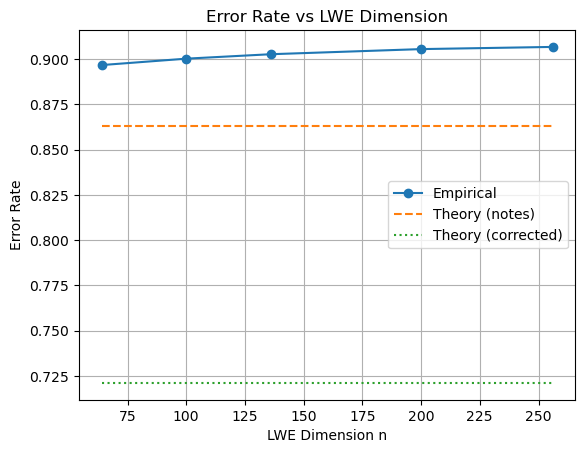

In [26]:
df_n = (
    df_results
    .groupby('n')
    .agg({
        'empirical_error_rate': 'mean',
        'theory_notes': 'mean',
        'theory_corrected': 'mean'
    })
    .reset_index()
)

plt.figure()
plt.plot(df_n['n'], df_n['empirical_error_rate'], marker='o', label='Empirical')
plt.plot(df_n['n'], df_n['theory_notes'], linestyle='--', label='Theory (notes)')
plt.plot(df_n['n'], df_n['theory_corrected'], linestyle=':', label='Theory (corrected)')
plt.xlabel('LWE Dimension n')
plt.ylabel('Error Rate')
plt.title('Error Rate vs LWE Dimension')
plt.legend()
plt.grid(True)
plt.show()


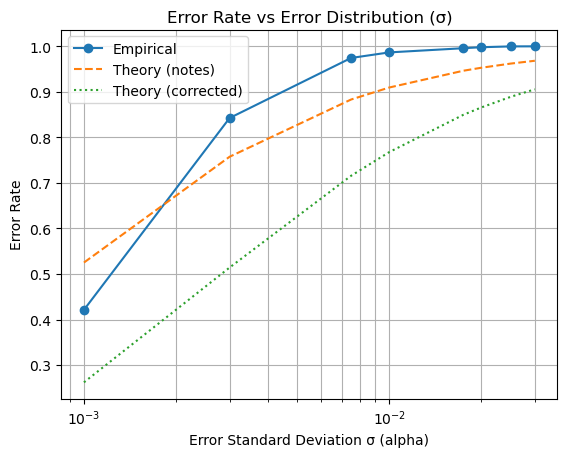

In [13]:
df_alpha = (
    df_results
    .groupby('alpha')
    .agg({
        'empirical_error_rate': 'mean',
        'theory_notes': 'mean',
        'theory_corrected': 'mean'
    })
    .reset_index()
)

plt.figure()
plt.semilogx(df_alpha['alpha'], df_alpha['empirical_error_rate'],
             marker='o', label='Empirical')
plt.semilogx(df_alpha['alpha'], df_alpha['theory_notes'],
             linestyle='--', label='Theory (notes)')
plt.semilogx(df_alpha['alpha'], df_alpha['theory_corrected'],
             linestyle=':', label='Theory (corrected)')

plt.xlabel('Error Standard Deviation σ (alpha)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Error Distribution (σ)')
plt.legend()
plt.grid(True, which='both')
plt.show()

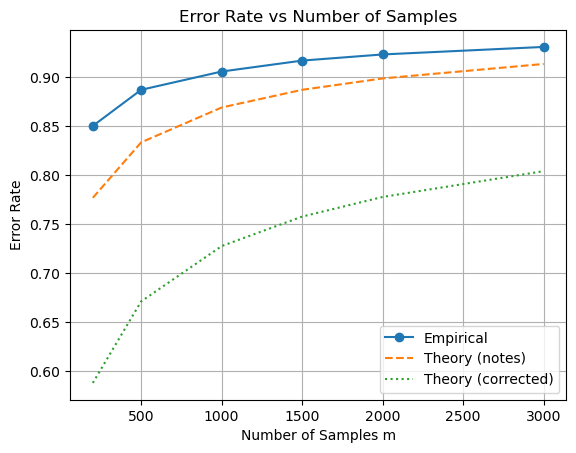

In [14]:
df_m = (
    df_results
    .groupby('m')
    .agg({
        'empirical_error_rate': 'mean',
        'theory_notes': 'mean',
        'theory_corrected': 'mean'
    })
    .reset_index()
)

plt.figure()
plt.plot(df_m['m'], df_m['empirical_error_rate'], marker='o', label='Empirical')
plt.plot(df_m['m'], df_m['theory_notes'], linestyle='--', label='Theory (notes)')
plt.plot(df_m['m'], df_m['theory_corrected'], linestyle=':', label='Theory (corrected)')
plt.xlabel('Number of Samples m')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Number of Samples')
plt.legend()
plt.grid(True)
plt.show()


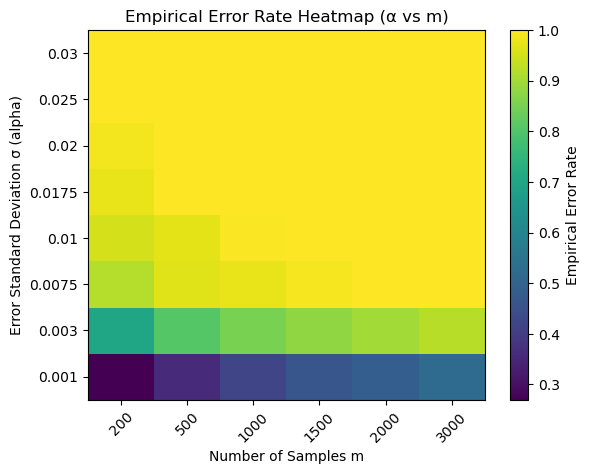

In [15]:
pivot = df_results.pivot_table(
    values='empirical_error_rate',
    index='alpha',
    columns='m',
    aggfunc='mean'
)

pivot = pivot.apply(pd.to_numeric, errors='coerce')

plt.figure()
plt.imshow(pivot.values, aspect='auto', origin='lower')
plt.colorbar(label='Empirical Error Rate')
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel('Number of Samples m')
plt.ylabel('Error Standard Deviation σ (alpha)')
plt.title('Empirical Error Rate Heatmap (α vs m)')
plt.show()


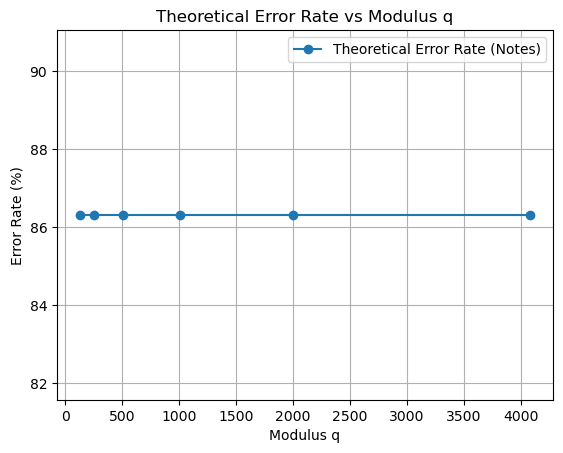

In [22]:
df_q = (
    df_results
    .groupby('q')
    .agg({
        'theory_notes': 'mean'
    })
    .reset_index()
)

# Convert to native Python floats (important for Sage)
df_q['q'] = df_q['q'].astype(int)
df_q['theory_notes'] = df_q['theory_notes'].astype(float)

# Convert to percentage
df_q['theory_error_percent'] = 100 * df_q['theory_notes']

plt.figure()
plt.plot(
    df_q['q'],
    df_q['theory_error_percent'],
    marker='o',
    linestyle='-',
    label='Theoretical Error Rate (Notes)'
)

plt.xlabel('Modulus q')
plt.ylabel('Error Rate (%)')
plt.title('Theoretical Error Rate vs Modulus q')
plt.grid(True)
plt.legend()
plt.show()


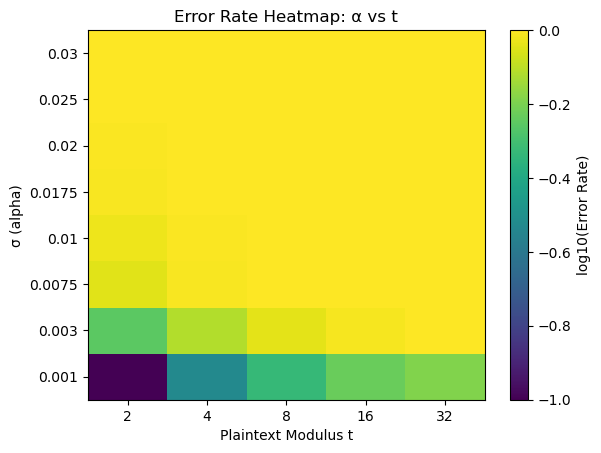

In [17]:
pivot_t_alpha = (
    df_results
    .pivot_table(
        values='empirical_error_rate',
        index='alpha',
        columns='t',
        aggfunc='mean'
    )
    .apply(pd.to_numeric, errors='coerce')
)

plt.figure()
plt.imshow(np.log10(pivot_t_alpha.values + 1e-12),
           aspect='auto', origin='lower')
plt.colorbar(label='log10(Error Rate)')
plt.xticks(range(len(pivot_t_alpha.columns)), pivot_t_alpha.columns)
plt.yticks(range(len(pivot_t_alpha.index)), pivot_t_alpha.index)
plt.xlabel('Plaintext Modulus t')
plt.ylabel('σ (alpha)')
plt.title('Error Rate Heatmap: α vs t')
plt.show()


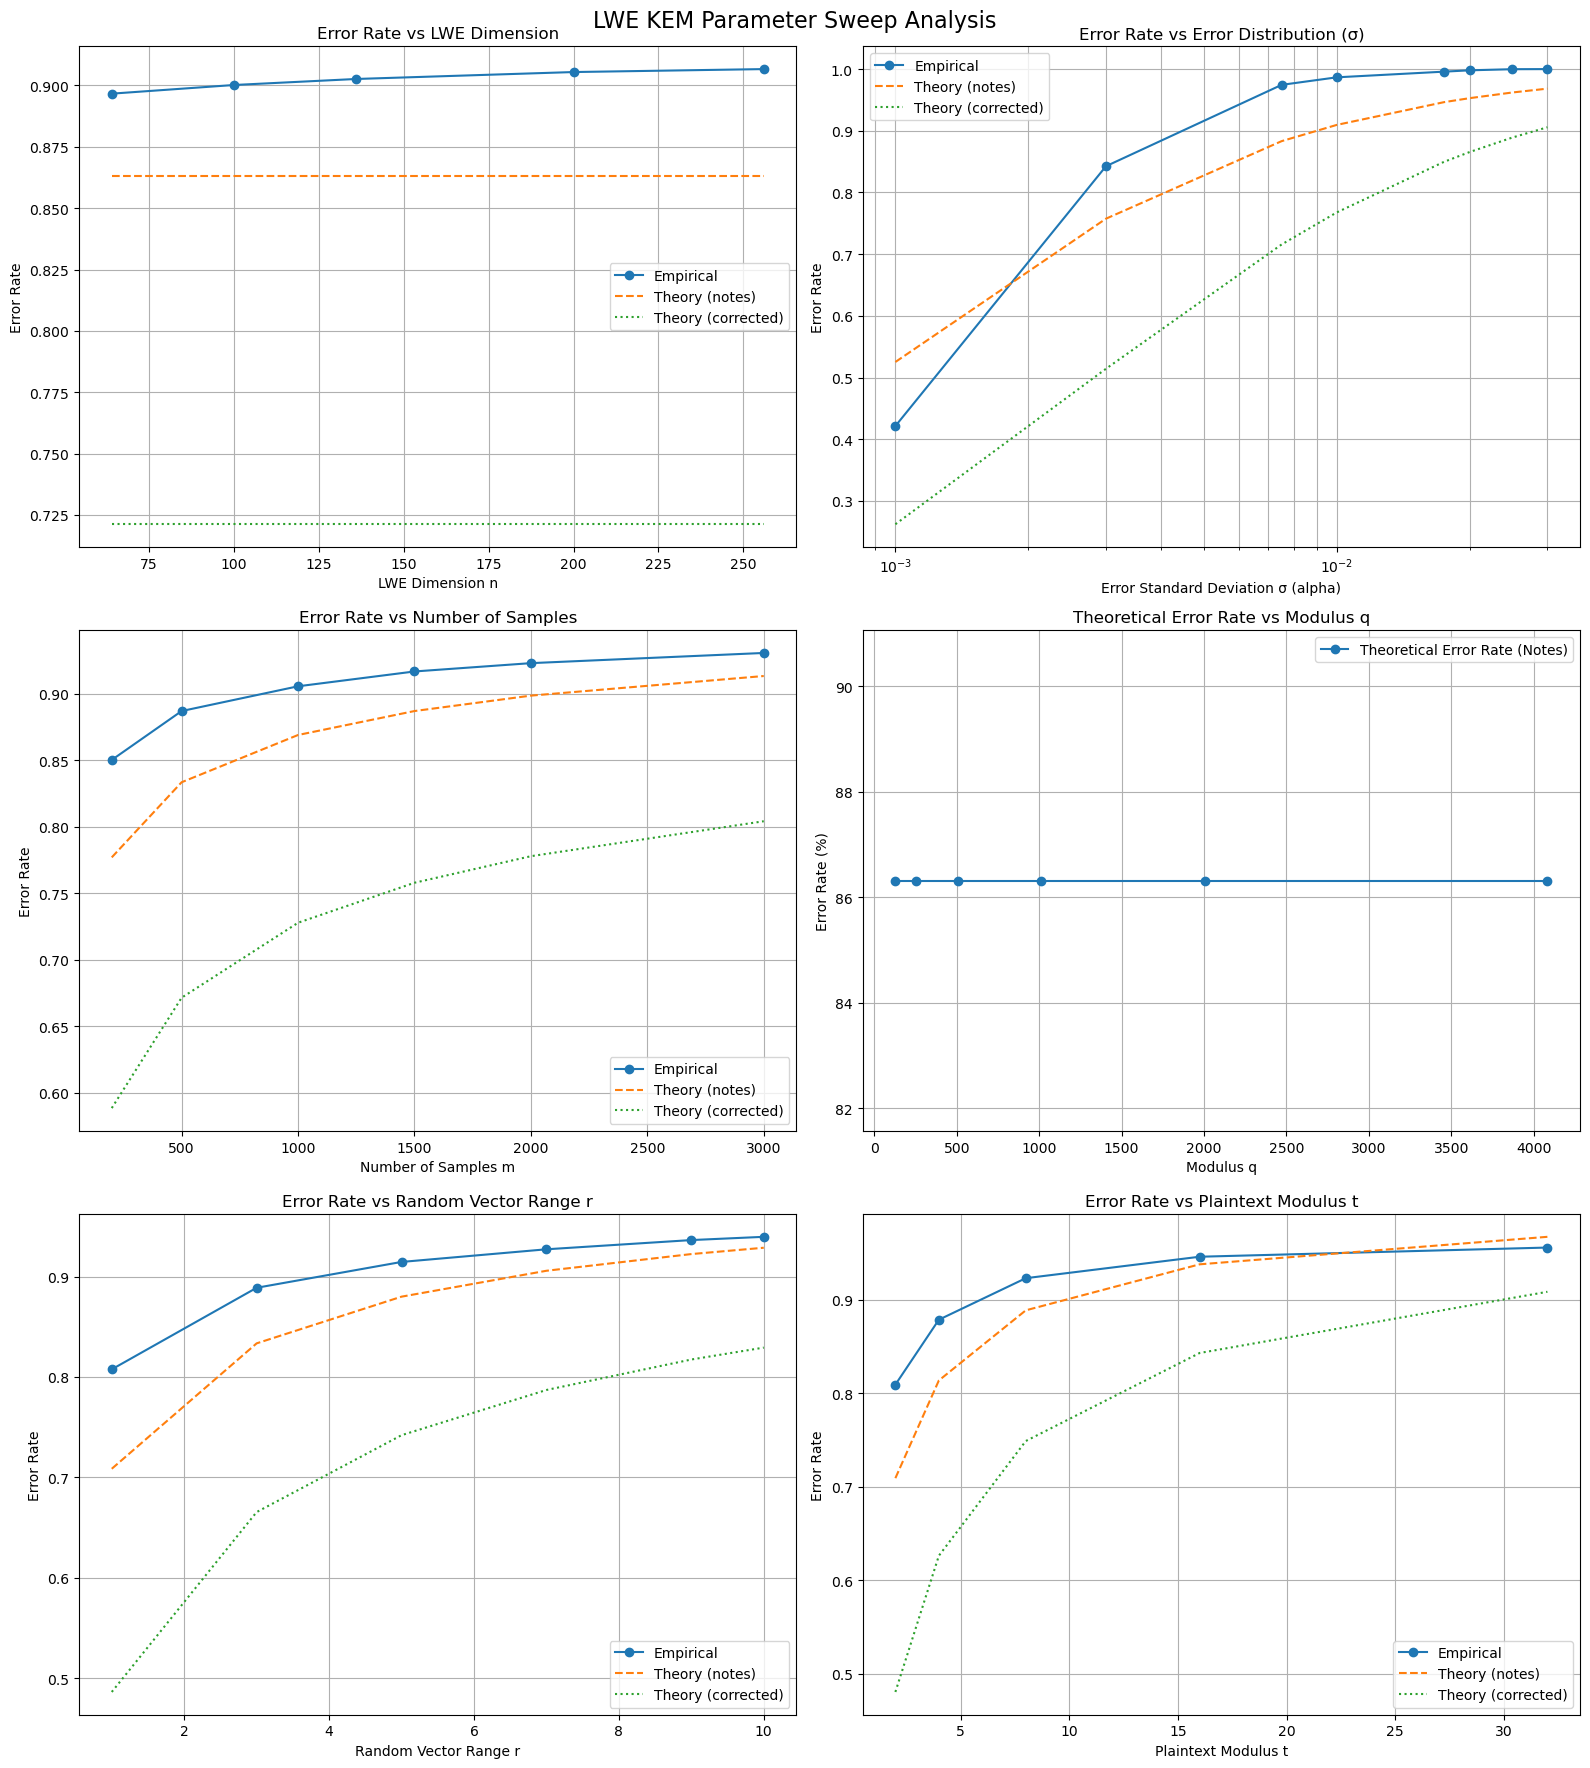

In [31]:
# Combined Line Plots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('LWE KEM Parameter Sweep Analysis', fontsize=16)

# 1. Error Rate vs LWE Dimension n
df_n = df_results.groupby('n')[['empirical_error_rate', 'theory_notes', 'theory_corrected']].mean().reset_index()
axes[0, 0].plot(df_n['n'], df_n['empirical_error_rate'], marker='o', label='Empirical')
axes[0, 0].plot(df_n['n'], df_n['theory_notes'], linestyle='--', label='Theory (notes)')
axes[0, 0].plot(df_n['n'], df_n['theory_corrected'], linestyle=':', label='Theory (corrected)')
axes[0, 0].set_xlabel('LWE Dimension n')
axes[0, 0].set_ylabel('Error Rate')
axes[0, 0].set_title('Error Rate vs LWE Dimension')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Error Rate vs Error Distribution (alpha)
df_alpha = df_results.groupby('alpha')[['empirical_error_rate', 'theory_notes', 'theory_corrected']].mean().reset_index()
axes[0, 1].semilogx(df_alpha['alpha'], df_alpha['empirical_error_rate'], marker='o', label='Empirical')
axes[0, 1].semilogx(df_alpha['alpha'], df_alpha['theory_notes'], linestyle='--', label='Theory (notes)')
axes[0, 1].semilogx(df_alpha['alpha'], df_alpha['theory_corrected'], linestyle=':', label='Theory (corrected)')
axes[0, 1].set_xlabel('Error Standard Deviation σ (alpha)')
axes[0, 1].set_ylabel('Error Rate')
axes[0, 1].set_title('Error Rate vs Error Distribution (σ)')
axes[0, 1].legend()
axes[0, 1].grid(True, which='both')

# 3. Error Rate vs Number of Samples m
df_m = df_results.groupby('m')[['empirical_error_rate', 'theory_notes', 'theory_corrected']].mean().reset_index()
axes[1, 0].plot(df_m['m'], df_m['empirical_error_rate'], marker='o', label='Empirical')
axes[1, 0].plot(df_m['m'], df_m['theory_notes'], linestyle='--', label='Theory (notes)')
axes[1, 0].plot(df_m['m'], df_m['theory_corrected'], linestyle=':', label='Theory (corrected)')
axes[1, 0].set_xlabel('Number of Samples m')
axes[1, 0].set_ylabel('Error Rate')
axes[1, 0].set_title('Error Rate vs Number of Samples')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 4. Theoretical Error Rate vs Modulus q
df_q = df_results.groupby('q')[['theory_notes']].mean().reset_index()
df_q['q'] = df_q['q'].astype(int)
df_q['theory_notes'] = df_q['theory_notes'].astype(float)
df_q['theory_error_percent'] = 100 * df_q['theory_notes']
axes[1, 1].plot(df_q['q'], df_q['theory_error_percent'], marker='o', linestyle='-', label='Theoretical Error Rate (Notes)')
axes[1, 1].set_xlabel('Modulus q')
axes[1, 1].set_ylabel('Error Rate (%)')
axes[1, 1].set_title('Theoretical Error Rate vs Modulus q')
axes[1, 1].grid(True)
axes[1, 1].legend()

# 5. Error Rate vs Random Vector Range r
df_r = df_results.groupby('r')[['empirical_error_rate', 'theory_notes', 'theory_corrected']].mean().reset_index()
axes[2, 0].plot(df_r['r'], df_r['empirical_error_rate'], marker='o', label='Empirical')
axes[2, 0].plot(df_r['r'], df_r['theory_notes'], linestyle='--', label='Theory (notes)')
axes[2, 0].plot(df_r['r'], df_r['theory_corrected'], linestyle=':', label='Theory (corrected)')
axes[2, 0].set_xlabel('Random Vector Range r')
axes[2, 0].set_ylabel('Error Rate')
axes[2, 0].set_title('Error Rate vs Random Vector Range r')
axes[2, 0].legend()
axes[2, 0].grid(True)

# 6. Error Rate vs Plaintext Modulus t
df_t = df_results.groupby('t')[['empirical_error_rate', 'theory_notes', 'theory_corrected']].mean().reset_index()
axes[2, 1].plot(df_t['t'], df_t['empirical_error_rate'], marker='o', label='Empirical')
axes[2, 1].plot(df_t['t'], df_t['theory_notes'], linestyle='--', label='Theory (notes)')
axes[2, 1].plot(df_t['t'], df_t['theory_corrected'], linestyle=':', label='Theory (corrected)')
axes[2, 1].set_xlabel('Plaintext Modulus t')
axes[2, 1].set_ylabel('Error Rate')
axes[2, 1].set_title('Error Rate vs Plaintext Modulus t')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

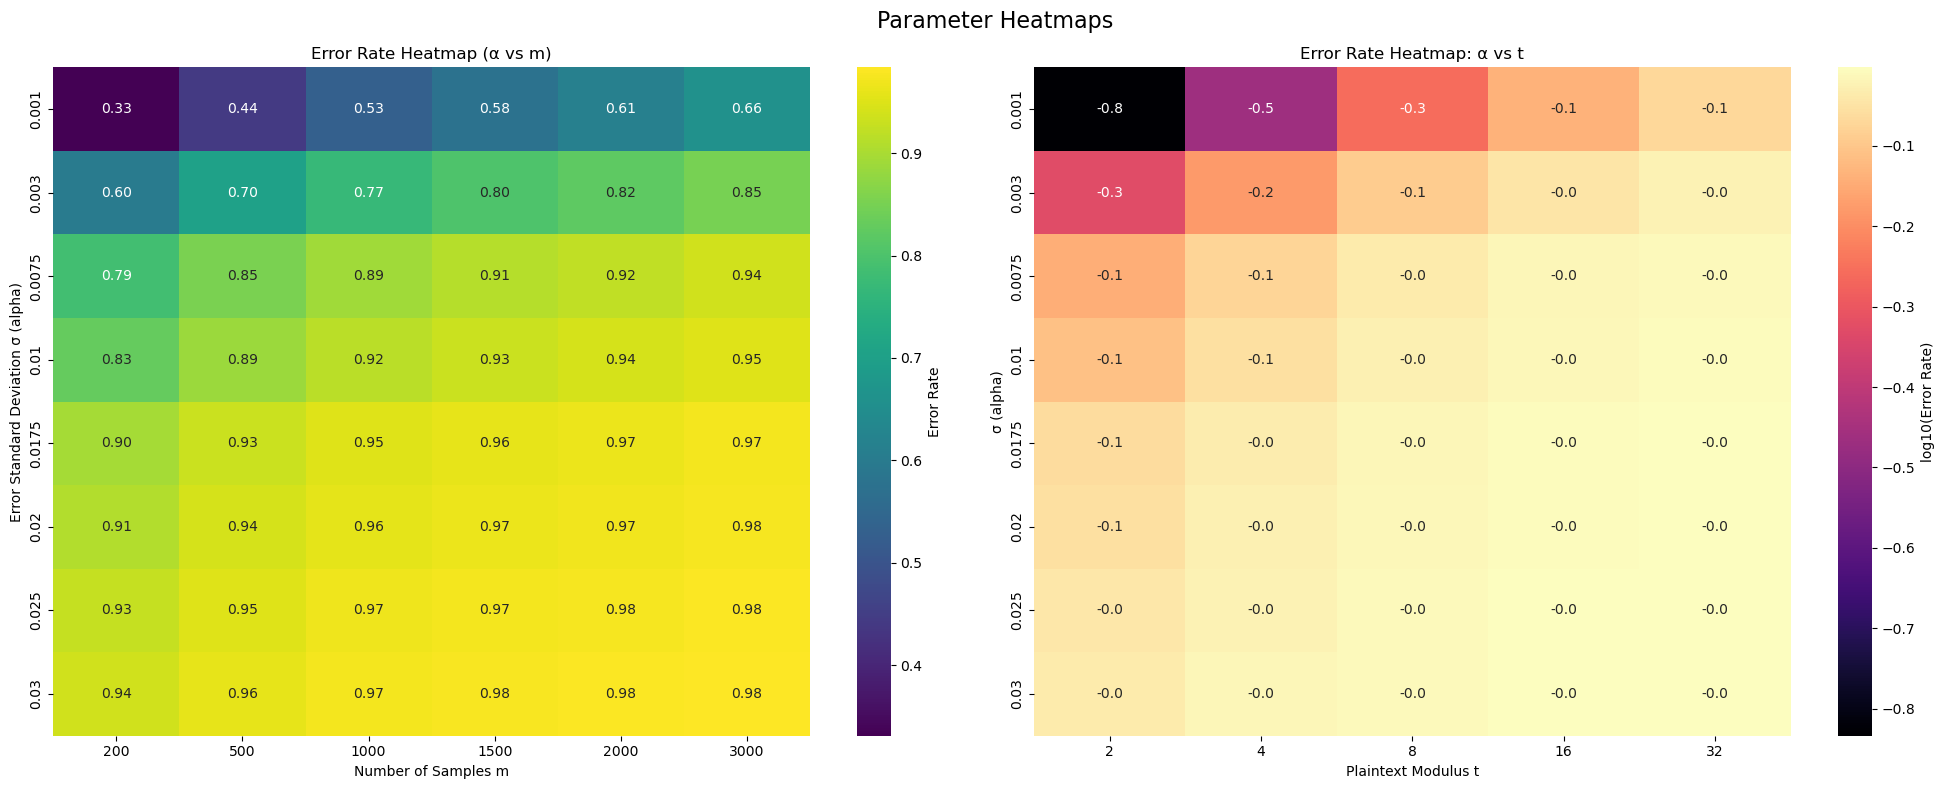

In [30]:
import seaborn as sns

# Combined Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Parameter Heatmaps', fontsize=16)

# 1. Empirical Error Rate Heatmap (alpha vs m)
pivot_m_alpha = df_results.pivot_table(
    values='theory_notes',
    index='alpha',
    columns='m',
    aggfunc='mean'
).apply(pd.to_numeric, errors='coerce')

sns.heatmap(pivot_m_alpha, ax=axes[0], cmap='viridis', annot=True, fmt='.2f', cbar_kws={'label': 'Error Rate'})
axes[0].set_title('Error Rate Heatmap (α vs m)')
axes[0].set_xlabel('Number of Samples m')
axes[0].set_ylabel('Error Standard Deviation σ (alpha)')

# 2. Error Rate Heatmap: alpha vs t
pivot_t_alpha = df_results.pivot_table(
    values='theory_notes',
    index='alpha',
    columns='t',
    aggfunc='mean'
).apply(pd.to_numeric, errors='coerce')

# Using log scale for visualization
log_pivot_t_alpha = np.log10(pivot_t_alpha + 1e-12)
sns.heatmap(log_pivot_t_alpha, ax=axes[1], cmap='magma', annot=True, fmt='.1f', cbar_kws={'label': 'log10(Error Rate)'})
axes[1].set_title('Error Rate Heatmap: α vs t')
axes[1].set_xlabel('Plaintext Modulus t')
axes[1].set_ylabel('σ (alpha)')

plt.tight_layout()
plt.show()